# Stack Overflow Topic Search

Created: 15 Dec 2021  
Last edited: 20 Dec 2021

## Setup to use this notebook

1. Set up your Python environment.

```
# create a new conda env called "topic"
conda create --name topic
conda activate topic

# install packages
conda install -c anaconda pyyaml pandas nltk gensim
conda install -c conda-forge jupyterlab jira wordcloud matplotlib spacy
pip install stackapi
```

2. Request access to the teams Stack Overflow by registering a new app on Stack Apps.

  Follow the instructions on [Stack Overflow for Teams API](https://stackoverflow.help/en/articles/4385859-stack-overflow-for-teams-api). Use `stackexchange.com` for the OAuth domain ([source](https://stackapps.com/a/7858)) and for the application website (where users go to read about the application).
  

3. Call `jupyter notebook` in the terminal to open the Jupyter home page and select this notebook.

## References
* Stack Exchange's [API reference docs](https://api.stackexchange.com/docs/)

In [1]:
import json
import pickle
import re
import requests

import gensim
import spacy
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

/Users/victorialim/miniconda3/envs/topic/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
# do this one time only
#import nltk
#nltk.download('stopwords')
#spacy.cli.download("en_core_web_sm")

In [4]:
BASE_URL = "https://api.stackexchange.com/2.3"
TEAM_NAME = "imply"
APP_KEY = "j3Szw*w)dq4OdYMDepWyKQ(("
ACCESS_TOKEN = "YOUR_TOKEN_HERE"

headers = {
  'X-API-Access-Token': ACCESS_TOKEN,
}

## Run a test request to check the connection

In [5]:
url = f"{BASE_URL}/questions?order=desc&sort=activity&site=stackoverflow&team=stackoverflow.com%2fc%2f{TEAM_NAME}&key={APP_KEY}"
response = requests.request("GET", url, headers=headers)
pretty_json = json.loads(response.text)
print(json.dumps(pretty_json, indent=2))

{
  "items": [
    {
      "tags": [
        "eng-platform",
        "platform"
      ],
      "owner": {
        "account_id": 17961736,
        "reputation": 726,
        "user_id": 32,
        "user_type": "registered",
        "profile_image": "https://stackoverflow.com/c/imply/images/s/a4d95b45-3857-45d9-b0d9-49025ada6234.png?s=256&g=1",
        "display_name": "Siva Mannem",
        "link": "https://stackoverflow.com/c/imply/users/32/siva-mannem"
      },
      "is_answered": true,
      "view_count": 24,
      "accepted_answer_id": 4414,
      "answer_count": 1,
      "score": 0,
      "last_activity_date": 1641495845,
      "creation_date": 1641439269,
      "last_edit_date": 1641491294,
      "question_id": 4404,
      "link": "https://stackoverflow.com/c/imply/questions/4404/validationerror-the-instance-i-0809ef9f26e7f09b7-is-not-part-of-auto-scaling-gr",
      "title": "ValidationError: The instance i-0809ef9f26e7f09b7 is not part of Auto Scaling group"
    },
    {
      "t

## View a single search result

The `search/excerpts` API searches questions and answers on the site. This search is more limited than the web interface search. For example, searching "time_floor" as of 12/20/18 returns 3 results via the API and 14 via the web UI. It looks like the API does not capture results when "time_floor" is in a code block or code-formatted text.

"time_parse" is another query to view the differences easily.

In [6]:
SEARCH_TERM = "query"

In [7]:
url = f"{BASE_URL}/search/excerpts?order=desc&sort=activity&body={SEARCH_TERM}&site=stackoverflow&team=stackoverflow.com%2fc%2f{TEAM_NAME}&key={APP_KEY}"
response = requests.request("GET", url, headers=headers)
#print(response.text)

data = response.json()
data["items"][0]

{'tags': ['eng-platform', 'platform'],
 'question_score': 0,
 'is_accepted': False,
 'has_accepted_answer': True,
 'answer_count': 1,
 'is_answered': True,
 'question_id': 4404,
 'item_type': 'question',
 'score': 0,
 'last_activity_date': 1641495845,
 'creation_date': 1641439269,
 'body': 'One of our customers in us-east-1 is facing this issue when trying to change query node from c5.2xlarge to c5.4xlarge\nValidationError: The instance i-0809ef9f26e7f09b7 is not part of Auto Scaling group imply-9a68f050-c237-4e5a-ae9e-deafa976acbb-Query-KW58RH01X8XL-AutoScalingGroup-BOWXOKKZD7WX.\nThey also have following overrides\n\nHow can we fix this issue ?\nThank you so much\n',
 'excerpt': 'One of our customers in us-east-1 is facing this issue when trying to change <span class="highlight">query</span> node from c5.2xlarge to c5.4xlarge\nValidationError: The instance i-0809ef9f26e7f09b7 is not part of Auto Scaling group &hellip; imply-9a68f050-c237-4e5a-ae9e-deafa976acbb-<span class="highlight"

## Collect search results in a list

NOTE: There is a bug in this cell that causes the `while` loop to evaluate infinitely. I'm not sure why the `keep_going` variable isn't properly set to False when `data["has_more"]` is False. As a workaround, use `custom_page_limit` to truncate the loop at a certain page count to prevent the notebook from running forever. (This is also why I have to remove duplicates in the second cell of this section.)

In [5]:
result_bodies = []
custom_page_limit = 50 # 30 results per page, use web UI to estimate page count

search_terms = ["query", "queries", "querying", "queried"]

for st in search_terms:

    page = 0
    keep_going = True
    url = f"{BASE_URL}/search/excerpts?order=desc&sort=activity&body={st}&site=stackoverflow&team=stackoverflow.com%2fc%2f{TEAM_NAME}&key={APP_KEY}#page={page}"
    print(f"searching: {st}")

    while keep_going and page < custom_page_limit:

        # increment page number of results
        page += 1
        if page%10 == 0:
            print(f"On page {page}")

        # make request
        response = requests.request("GET", url, headers=headers)
        data = response.json()

        # extract results, mydata is a list of dicts
        mydata = data["items"]
        for mydict in mydata:
            result_bodies.append(mydict["body"])

        keep_going = data["has_more"]

searching: query
On page 10
On page 20
On page 30
On page 40
On page 50
searching: queries
On page 10
On page 20
On page 30
On page 40
On page 50
searching: querying
On page 10
On page 20
On page 30
On page 40
On page 50
searching: queried


In [6]:
# remove duplicates
print(len(result_bodies))
result_bodies = list(set(result_bodies))
print(len(result_bodies))

4515
92


In [25]:
# save result to, or read results from disk

#pickle.dump( result_bodies, open( "save.pickle", "wb" ) )

result_bodies = pickle.load( open( "save.pickle", "rb" ) )

In [26]:
result_bodies

['Is it possibleto allow Users to only Access one Dashboard and the preconfigured Filters.\nSo this would mean that the user can not do any further Drilldown and also does not have access to the Values for Filters.\nIt would be great to have a way of only sharing the Data which is queried by the Dashboard and not allow anything else.\nWe are aware of the embedding Functionality in Pivot, however the user can easily circumvent this restriction by just visiting the normal Pivot UI.\nWe are also aware of the Filter Tokens, however since some of the Dashboards are very &quot;short lived&quot; (eg. only used during an Incident in the Network) this does not seems like a very easy to implement Solution.\nIs there some way of achieving this in Pivot or is this planned to be implemented?\n',
 'Customer is in AWS cloud using imply cloud. while trying to access public load balancer endpoint to query it is giving a timeout exception. The same LB is used to work earlier. Tried to get some info usin

In [27]:
# define stop words to ignore
custom_words = ["query", "use", "quot", "datum", "druid", "time", "segment", "may", "want", "one", "run", "see"]
ENGLISH_STOP_WORDS = set( stopwords.words('english') ).union(custom_words)


def remove_URL(sample):
    """Remove URLs from a sample string
    https://gist.github.com/MrEliptik/b3f16179aa2f530781ef8ca9a16499af"""
    return re.sub(r"http\S+", "", sample)

def tokenize(sentence):
    gen = gensim.utils.simple_preprocess(sentence, deacc=True)
    return ' '.join(gen)

def remove_stopwords(text):
    text_list = text.split()
    filtered_sentence = [w for w in text_list if not w in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence)

def lemmatize(nlp, text):
    # remove URLs
    text = remove_URL(text)
    
    # parse sentence using spacy
    # https://spacy.io/usage/spacy-101#pipelines
    doc = nlp(text) 
  
    # convert words into their simplest form (singular, present form, etc.)
    lemma = []
    for token in doc:
        if (token.lemma_ not in ['-PRON-']):
            lemma.append(token.lemma_)
    
    # lowercase, tokenize, rejoin
    token_text = tokenize(' '.join(lemma))
    
    # remove stopwords
    go_text = remove_stopwords(token_text)
          
    return go_text

In [28]:
# convert words to basic forms by lemmatizing
nlp = spacy.load("en_core_web_sm", disable=['ner'])
result_bodies = [lemmatize(nlp, x) for x in result_bodies]

# aggregate all records into one large string
large_string = ' '.join(result_bodies)
print(large_string[:100])

possibleto allow user access dashboard preconfigure filters would mean user drilldown also access va


## Visualize term frequencies

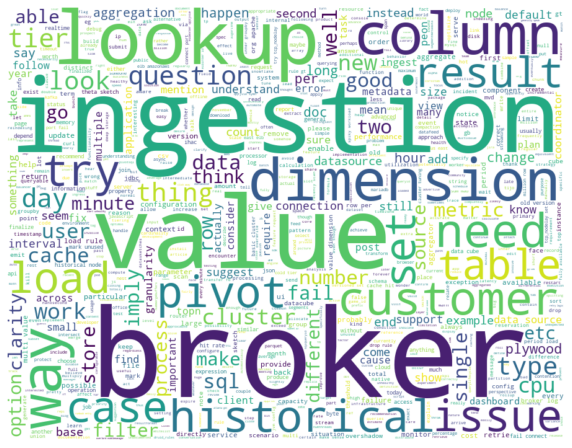

In [29]:
# apply stop words and run wordcloud on term frequency
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

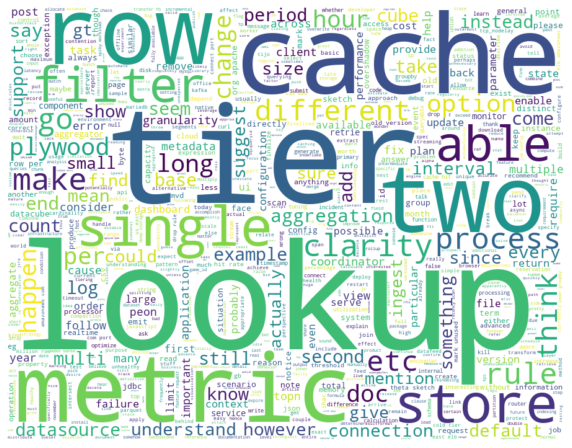

In [51]:
# apply stop words and run wordcloud on term frequency
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    contour_width=3, 
    contour_color='steelblue',
    stopwords=ENGLISH_STOP_WORDS.union(["value", "broker", "would", "like", "also", "get", "way", 
                                        "need", "customer", "issue", "ingestion", "dimension", "column", 
                                        "historical", "try", "load", "pivot", "set", "result", "table", 
                                        "case", "question", "look", "thing", "day", "type", "cluster",
                                        "new", "work", "fail", "user", "cpu", "data", "source", 
                                        "well", "good", "node", "sql", "imply", "number", "minute"
                                       ]),
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Determine most frequent bigrams

In [52]:
# https://www.nltk.org/howto/collocations.html
# tokenize string then analyze bigrams
tokens = gensim.utils.simple_preprocess(large_string, deacc=True)
pairs = nltk.bigrams(tokens)

# construct a BigramCollocationFinder for all bigrams in the given sequence
# it's a tool for the finding and ranking bigram collocations
finder = nltk.collocations.BigramCollocationFinder.from_words(pairs)

# ignore all bigrams which occur less than three times in the corpus
finder.apply_freq_filter(3)

# list top ten bigram collocations, as measured using Pointwise Mutual Information
bigram_measures = nltk.collocations.BigramAssocMeasures()
words = finder.nbest(bigram_measures.pmi, 10)

d = sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:20]
d

[((('multi', 'value'), ('value', 'dimension')), 6),
 ((('cache', 'hit'), ('hit', 'rate')), 5),
 ((('period', 'load'), ('load', 'rule')), 5),
 ((('amazonaws', 'com'), ('com', 'port')), 4),
 ((('basic', 'cluster'), ('cluster', 'tuning')), 4),
 ((('connect', 'port'), ('port', 'fail')), 4),
 ((('east', 'elb'), ('elb', 'amazonaws')), 4),
 ((('elb', 'amazonaws'), ('amazonaws', 'com')), 4),
 ((('load', 'rule'), ('rule', 'gt')), 4),
 ((('multi', 'dimension'), ('dimension', 'column')), 4),
 ((('try', 'tcp_nodelay'), ('tcp_nodelay', 'set')), 4),
 ((('us', 'east'), ('east', 'elb')), 4),
 ((('connection', 'fail'), ('fail', 'connect')), 3),
 ((('million', 'row'), ('row', 'per')), 3),
 ((('number', 'row'), ('row', 'per')), 3),
 ((('sum', 'mau'), ('mau', 'gt')), 3)]

Text(0.5, 0, '# of Occurences')

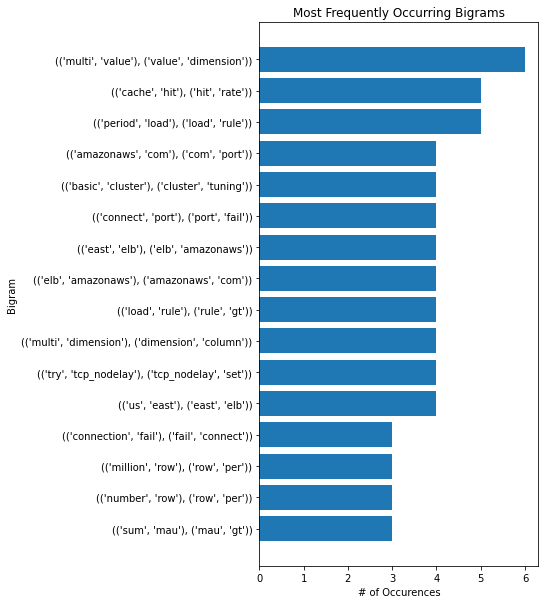

In [53]:
# visualize the bigram frequencies

wordlabels = list(zip(*reversed(d)))[0]
frequency = list(zip(*reversed(d)))[1]
x_pos = range(len(wordlabels)) 

plt.figure(figsize=(5,10))
plt.barh(x_pos, frequency, align='center')
plt.yticks(x_pos, wordlabels) 

plt.title('Most Frequently Occurring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurences')